In [34]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
from scipy.stats import mode

%matplotlib inline

In [35]:
# Reading training dataset
df = pd.read_csv('./dataset/Training.csv')

# Checking whether the dataset is balanced or not
df["prognosis"].value_counts()

prognosis
Common Cold                                120
Tuberculosis                               120
Hepatitis C                                120
Hepatitis D                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
AIDS                                       120
Osteoarthristis                            120
Psoriasis                                  120
Impetigo                                   120
Dimorphic hemmorhoids(piles)               120
Varicose veins                             120
Hyperthyroidism                            120
Hypoglycemia                               120
(vertigo) Paroymsal  Positional Vertigo    120
Drug Reaction                              120
Chicken pox                                120
Chronic cholestasis                        120
Diabetes                                   120
Malaria                                    120
Dengue                                     120
Bro

In [36]:
# Visualizing the dataset
df.head()

# Removing the last column as it's useless
# df.drop('Unnamed: 133', axis=1, inplace=True)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold


In [37]:
# Now our data is clean & we are good to go : )
df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold


In [38]:
for i in df.columns:
    print(i)

itching
skin_rash
nodal_skin_eruptions
continuous_sneezing
shivering
chills
joint_pain
stomach_pain
acidity
ulcers_on_tongue
muscle_wasting
vomiting
burning_micturition
spotting_ urination
fatigue
weight_gain
anxiety
cold_hands_and_feets
mood_swings
weight_loss
restlessness
lethargy
patches_in_throat
irregular_sugar_level
cough
high_fever
sunken_eyes
breathlessness
sweating
dehydration
indigestion
headache
yellowish_skin
dark_urine
nausea
loss_of_appetite
pain_behind_the_eyes
back_pain
constipation
abdominal_pain
diarrhoea
mild_fever
yellow_urine
yellowing_of_eyes
acute_liver_failure
fluid_overload
swelling_of_stomach
swelled_lymph_nodes
malaise
blurred_and_distorted_vision
phlegm
throat_irritation
redness_of_eyes
sinus_pressure
runny_nose
congestion
chest_pain
weakness_in_limbs
fast_heart_rate
pain_during_bowel_movements
pain_in_anal_region
bloody_stool
irritation_in_anus
neck_pain
dizziness
cramps
bruising
obesity
swollen_legs
swollen_blood_vessels
puffy_face_and_eyes
enlarged_thyroi

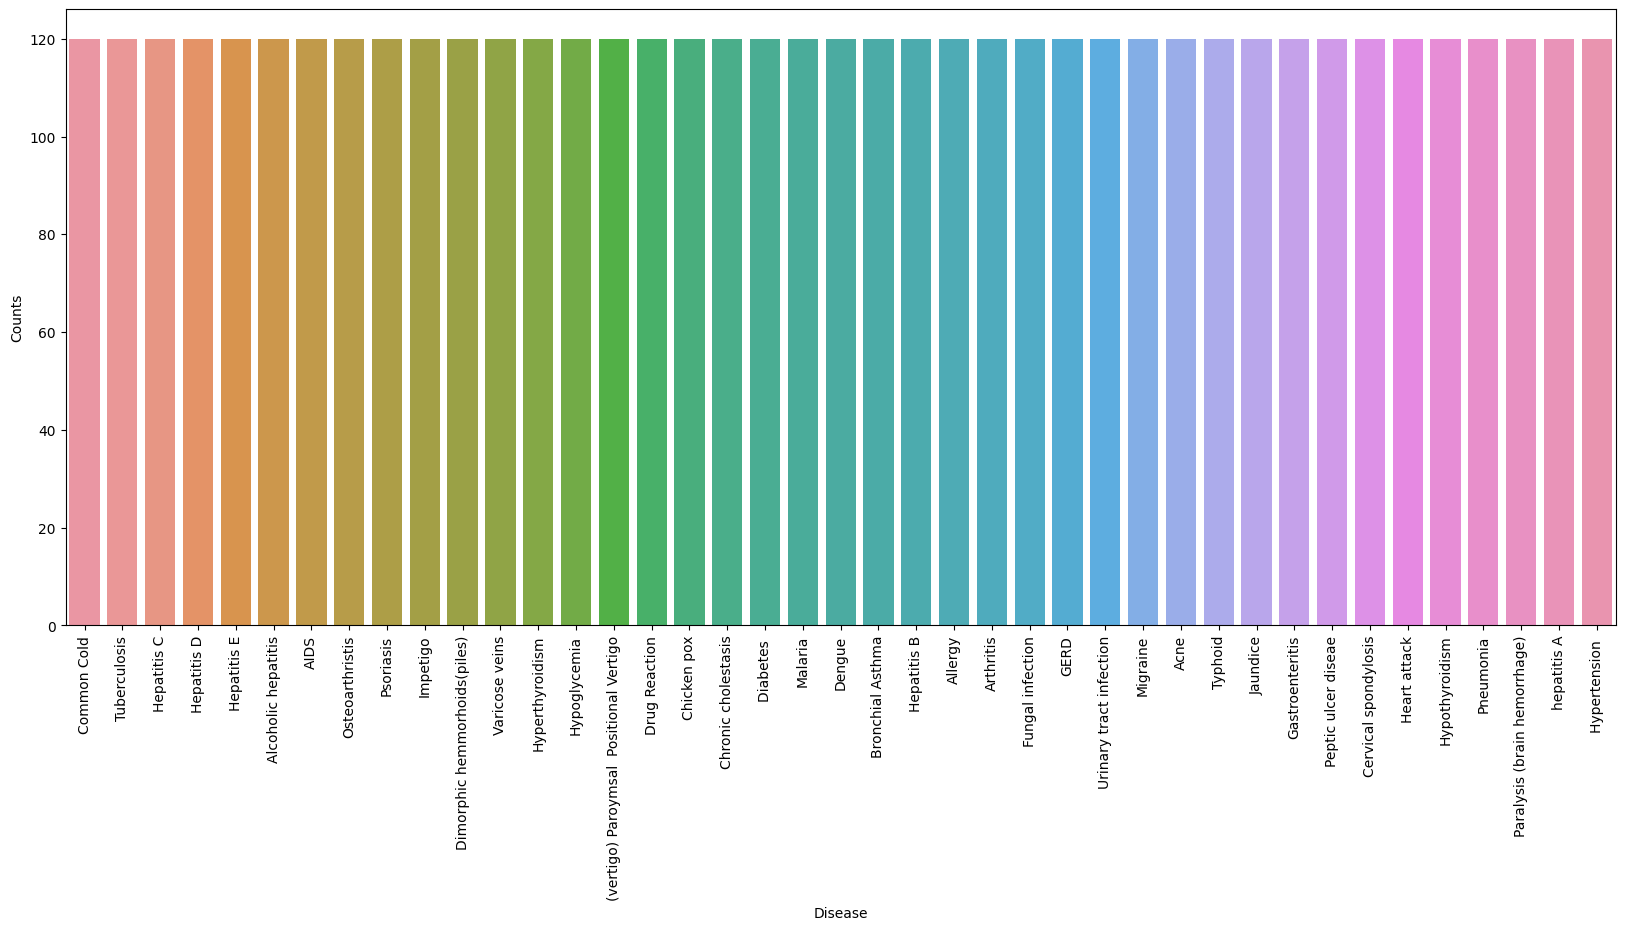

In [39]:
disease_counts = df["prognosis"].value_counts()
temp_df = pd.DataFrame({
    "Disease": disease_counts.index,
    "Counts": disease_counts.values
})

plt.figure(figsize = (20,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()

In [40]:
# Encoding the target value(object) into numerical value via LabelEncoder() 
encoder = LabelEncoder()
df["prognosis"] = encoder.fit_transform(df["prognosis"])

In [41]:
# Spliting Data into X and Y
X = df.drop('prognosis', axis=1)
y = df['prognosis']

In [42]:
X

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
y

0       10
1       10
2       10
3       10
4       10
        ..
4915    23
4916    23
4917    23
4918    23
4919    23
Name: prognosis, Length: 4920, dtype: int32

In [44]:
X.shape, y.shape

((4920, 132), (4920,))

In [45]:
# Splitting Data into training and test
X_train, X_test, y_train, y_test =train_test_split(
X, y, test_size = 0.2, random_state = 42)

print(f'Train: {X_train.shape}, {y_train.shape}')
print(f'Test: {X_test.shape}, {y_test.shape}')

Train: (3936, 132), (3936,)
Test: (984, 132), (984,)


In [46]:
# Defining scoring metric for k-fold cross validation
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

# Initializing Models
models = {
    "SVC":SVC(),
    "Gaussian NB":GaussianNB(),
    "Random Forest":RandomForestClassifier(random_state=18)
}

# Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    scores = cross_val_score(model, X, y, cv = 10,
                            n_jobs = -1,
                            scoring = cv_scoring)
    print("--"*30)
    print(model_name)
    print(f"Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")

------------------------------------------------------------
SVC
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
------------------------------------------------------------
Gaussian NB
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
------------------------------------------------------------
Random Forest
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0


Accuracy on train data by SVM Classifier: 100.0
Accuracy on test data by SVM Classifier: 100.0


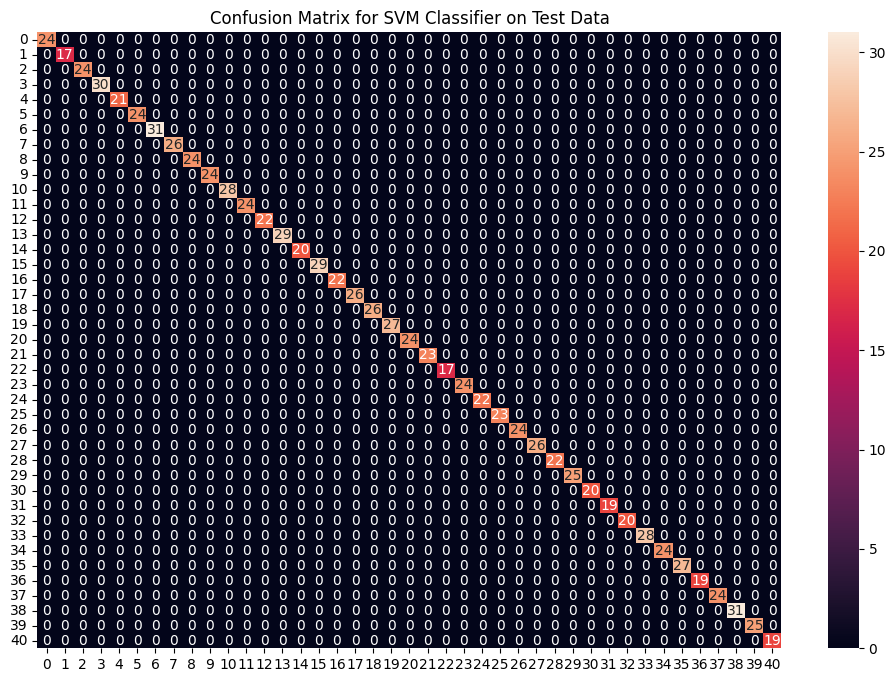

Accuracy on train data by Naive Bayes Classifier: 100.0
Accuracy on test data by Naive Bayes Classifier: 100.0


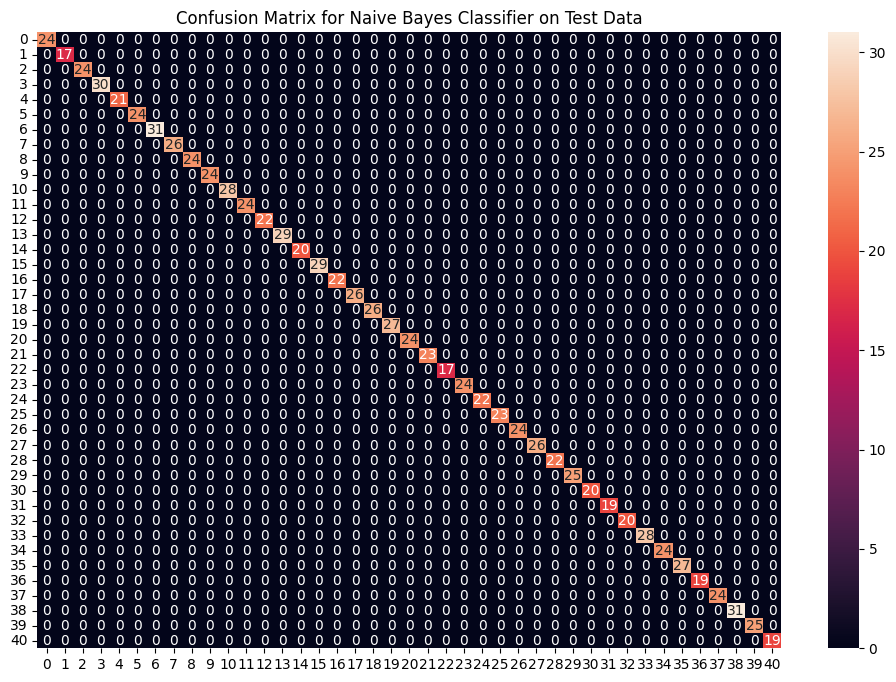

Accuracy on train data by Random Forest Classifier: 100.0
Accuracy on test data by Random Forest Classifier: 100.0


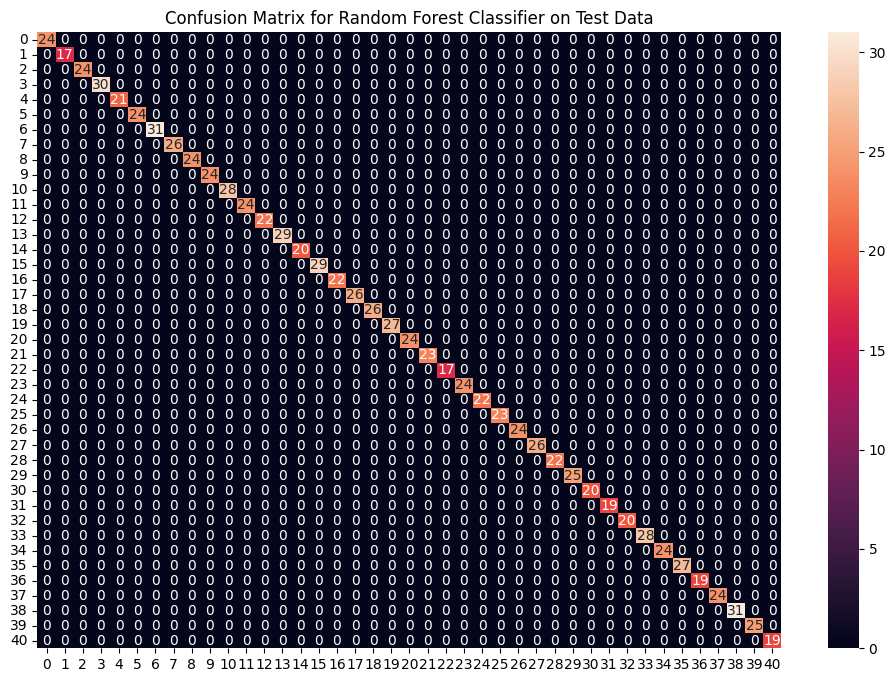

In [47]:
# Training and testing SVM Classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)

print(f"Accuracy on train data by SVM Classifier\
: {accuracy_score(y_train, svm_model.predict(X_train))*100}")

print(f"Accuracy on test data by SVM Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for SVM Classifier on Test Data")
plt.show()

# Training and testing Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
preds = nb_model.predict(X_test)
print(f"Accuracy on train data by Naive Bayes Classifier\
: {accuracy_score(y_train, nb_model.predict(X_train))*100}")

print(f"Accuracy on test data by Naive Bayes Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Naive Bayes Classifier on Test Data")
plt.show()

# Training and testing Random Forest Classifier
rf_model = RandomForestClassifier(random_state=18)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print(f"Accuracy on train data by Random Forest Classifier\
: {accuracy_score(y_train, rf_model.predict(X_train))*100}")

print(f"Accuracy on test data by Random Forest Classifier\
: {accuracy_score(y_test, preds)*100}")

cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()

Accuracy on Test dataset by the combined model: 97.61904761904762


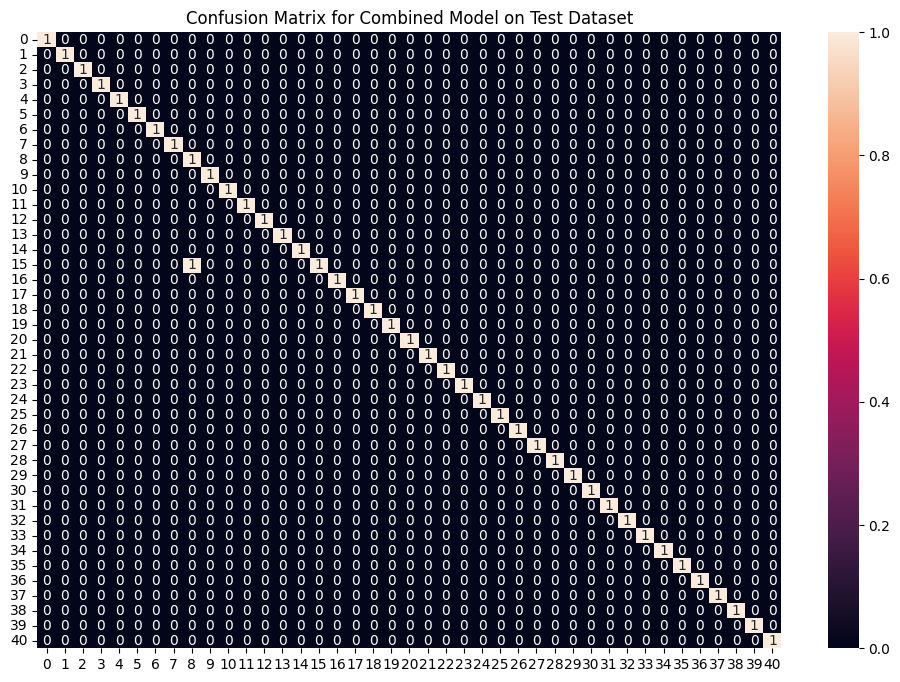

In [48]:
# Training the models on whole data
final_svm_model = SVC()
final_nb_model = GaussianNB()
final_rf_model = RandomForestClassifier(random_state=18)
final_svm_model.fit(X, y)
final_nb_model.fit(X, y)
final_rf_model.fit(X, y)

# Reading the test data
test_data = pd.read_csv("./dataset/Testing.csv").dropna(axis=1)

test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])

# Making prediction by take mode of predictions
# made by all the classifiers
svm_preds = final_svm_model.predict(test_X)
nb_preds = final_nb_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)

final_preds = final_preds = [mode([i,j,k], keepdims=True)[0][0] for i,j,k in 
zip(svm_preds, nb_preds, rf_preds)]

print(f"Accuracy on Test dataset by the combined model\
: {accuracy_score(test_Y, final_preds)*100}")

cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12,8))

sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()

In [49]:
symptoms = X.columns.values

# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
	symptom = " ".join([i.capitalize() for i in value.split("_")])
	symptom_index[symptom] = index

data_dict = {
	"symptom_index":symptom_index,
	"predictions_classes":encoder.classes_
}

#finding mode of all 3 models
def find_mode_or_nb(string_list): # nb is supposed to have max amount of good result
    counts = Counter(string_list)
    max_frequency = max(counts.values())
    modes = [string for string, count in counts.items() if count == max_frequency]

    return modes if len(modes)<1 else string_list[1]; 

# Defining the Function
# Input: string containing symptoms separated by commas
# Output: Generated predictions by models
def predictDisease(symptoms):
    # symptoms = symptoms.split(",")

    # Creating input data for the models
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"].get(symptom)
        if index is not None:
            input_data[index] = 5
        else:
            print(f"Warning: Symptom '{symptom}' is not valid.")

    # Reshaping the input data and converting it
    # into a suitable format for model predictions
    input_data = np.array(input_data).reshape(1, -1)
    print(data_dict["symptom_index"].keys())

    # Generating individual outputs
    rf_prediction = final_rf_model.predict(input_data)[0]
    nb_prediction = final_nb_model.predict(input_data)[0]
    svm_prediction = final_svm_model.predict(input_data)[0]
    

    # Making the final prediction by taking the mode of all predictions
    predictions = [data_dict["predictions_classes"][rf_prediction],
                   data_dict["predictions_classes"][nb_prediction],
                   data_dict["predictions_classes"][svm_prediction]]
    
    final_prediction = find_mode_or_nb(predictions)


    predictions = {
        "rf_model_prediction": data_dict["predictions_classes"][rf_prediction],
        "naive_bayes_prediction": data_dict["predictions_classes"][nb_prediction],
        "svm_model_prediction": data_dict["predictions_classes"][svm_prediction],
        "final_prediction": final_prediction
    }
    return predictions

# Testing the function
predictDisease( ['Painful Urination', 'Frequent Urination', 'Foul Smell Of urine', 'Abdominal Pain', 'Blood In Urine'])

# print(data_dict)

dict_keys(['Itching', 'Skin Rash', 'Nodal Skin Eruptions', 'Continuous Sneezing', 'Shivering', 'Chills', 'Joint Pain', 'Stomach Pain', 'Acidity', 'Ulcers On Tongue', 'Muscle Wasting', 'Vomiting', 'Burning Micturition', 'Spotting  urination', 'Fatigue', 'Weight Gain', 'Anxiety', 'Cold Hands And Feets', 'Mood Swings', 'Weight Loss', 'Restlessness', 'Lethargy', 'Patches In Throat', 'Irregular Sugar Level', 'Cough', 'High Fever', 'Sunken Eyes', 'Breathlessness', 'Sweating', 'Dehydration', 'Indigestion', 'Headache', 'Yellowish Skin', 'Dark Urine', 'Nausea', 'Loss Of Appetite', 'Pain Behind The Eyes', 'Back Pain', 'Constipation', 'Abdominal Pain', 'Diarrhoea', 'Mild Fever', 'Yellow Urine', 'Yellowing Of Eyes', 'Acute Liver Failure', 'Fluid Overload', 'Swelling Of Stomach', 'Swelled Lymph Nodes', 'Malaise', 'Blurred And Distorted Vision', 'Phlegm', 'Throat Irritation', 'Redness Of Eyes', 'Sinus Pressure', 'Runny Nose', 'Congestion', 'Chest Pain', 'Weakness In Limbs', 'Fast Heart Rate', 'Pain 

d:\gingervitis\Jupyter Notebook\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\gingervitis\Jupyter Notebook\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
d:\gingervitis\Jupyter Notebook\venv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


{'rf_model_prediction': 'Urinary tract infection',
 'naive_bayes_prediction': 'Urinary tract infection',
 'svm_model_prediction': 'Hepatitis D',
 'final_prediction': 'Urinary tract infection'}

In [50]:
# Saving Model using Pickle
import pickle

# Saving model 
pickle.dump(final_svm_model, open('./created_models/saved_final_svm_model.pkl', 'wb'))
pickle.dump(final_nb_model, open('./created_models/saved_final_nb_model.pkl', 'wb'))
pickle.dump(final_rf_model, open('./created_models/saved_final_rf_model.pkl', 'wb'))

In [51]:
# Loading Model From Pickle 
final_svm_model = pickle.load(open('./created_models/saved_final_svm_model.pkl', 'rb'))
print(final_svm_model.score(X_test, y_test)*100, '%')

100.0 %
